In [332]:
# from networks.pdhg_tgv import PdhgTgvTorch, PdhgTgvNumpy
from PIL import Image
import matplotlib.pyplot as plt

In [333]:
import torch
import torch.nn as nn
import numpy as np


class PdhgTgvSolver:
    """
    See page 17 in "Recovering piecewise smooth multichannel images..."
    https://unipub.uni-graz.at/obvugroa/content/titleinfo/125370
    """
    # Data-type-independent. User must ensure consistency.
    def __init__(
        self, 
        sigma, tau, nabla_h, e_h, div_h_v, div_h_w, P_alpha1, P_alpha0,
        convergence_limit
    ):
        print(f"convergence_limit: {convergence_limit}")
        excluded = ["self", "convergence_limit"]
        # Set all the attributes without repeating self.x = x
        for name, value in vars().items():
            if name not in excluded:
                setattr(self, name, value)
                
        while self.sigma * self.tau > convergence_limit:
            self.sigma /= 2
            self.tau /= 2
        print(f"sigma: {self.sigma}, tau: {self.tau}")
        
    def solve(self, u0, u, p, u_bar, p_bar, v, w, alpha1, alpha0, num_iters=100):
        print(f"Using data-type-independent solver")
        
        for i in range(num_iters):
            # print("Iteration: ", i)
            v_next = self.P_alpha1(v + self.sigma * (self.nabla_h(u_bar) - p_bar), alpha1)
            
            w_next = self.P_alpha0(w + self.sigma * self.e_h(p), alpha0)
            
            u_next = self.id_tauFh_inverse(u + self.tau * self.div_h_v(v_next), u0)
            
            p_next = p + self.tau * (v_next + self.div_h_w(w_next))
            
            u_bar = u_next * 2 - u
            p_bar = p_next * 2 - p
            
            u, p = u_next, p_next
            v, w = v_next, w_next

        del v_next, w_next, u_next, p_next # Explicitly free up memory
            
        return u
        
    def id_tauFh_inverse(self, x, x0):
        """
        Resolvent operator (id + τ∂Fh)^(-1)
        See page 15 in "Recovering piecewise smooth multichannel...", 3.2 - A Numerical Algorithm 
        """
        # Placeholder for (id + τ∂Fh)^(-1)
        # return x
        # return x / self.tau
        # See page 19 in "Recovering piecewise smooth multichannel..."
        return (x + self.tau * x0) / (self.tau + 1)
    
    
class GradOpsTorch:
    def grad_h(u):
        # $\Nabla_h$ and $\mathcal{E}_h$ ??? See page 13 in 'Recovering piecewise smooth multichannel...'
        # https://unipub.uni-graz.at/obvugroa/content/titleinfo/125370
        
        # Parameters
        # ----------
        # u : torch.Tensor
        #     Assume 2D tensor of shape [n, n] (for now).
            
        #     scalar field?
            
        # Returns
        # -------
        # grad_u : torch.Tensor
        #     Assume 3D tensor of shape [n, n, 2] (for now).
        #     The point is that, the shape of the output is one more dimension added to the end of input,
        #     and that extra last dimension is of size 2.
            
        #     Gradient of the scalar field u?
        # assert u.dim() == 2, f"u must be a 2D tensor, but got {u.dim()}D tensor"
        # Compute the gradient in both x and y directions
        grad_u = torch.zeros(u.size() + (2,), device=u.device)
        grad_u[..., 0] = torch.diff(u, n=1, dim=0, append=u[-1:, ...])  # Gradient in the x direction
        grad_u[..., 1] = torch.diff(u, n=1, dim=1, append=u[:, -1:])    # Gradient in the y direction
        return grad_u
    
    def div_h(v):
        """
        $\text{div}_h$. See page 14 in 'Recovering piecewise smooth multichannel...'
        https://unipub.uni-graz.at/obvugroa/content/titleinfo/125370
            
        Parameters
        ----------
        v : torch.Tensor
            Assume 3D tensor of shape [n, n, 2] (for now).
            The point is that, the shape of the input is one more dimension added to the end of the output,
            and that extra last dimension is of size 2.
            
            representing the vector field?
            
        Returns
        -------
        div_v : torch.Tensor
            Assume 2D tensor of shape [n, n] (for now).
            
            Divergence of the vector field v?
        """
        # assert v.dim() == 3, f"v must be a 3D tensor, but got {v.dim()}D tensor"
        # Compute the divergence from the gradient in both x and y directions
        div_v = torch.zeros(v.size()[:-1], device=v.device)
        div_v += torch.diff(v[..., 0], n=1, dim=0, prepend=v[0:1, ..., 0])  # Divergence in the x direction
        div_v += torch.diff(v[..., 1], n=1, dim=1, prepend=v[:, 0:1, ..., 1])  # Divergence in the y direction
        return div_v
    
class PdhgTgvTorch(nn.Module):
    # See page 17 in "Recovering piecewise smooth multichannel..." for the algorithm
    def __init__(self, device):
        super(PdhgTgvTorch, self).__init__() # Ensure proper initialisation
        self.device = device
        self.sigma = torch.tensor(1.0, device=device)
        self.tau = torch.tensor(1.0, device=device)
        self.theta = torch.tensor(1.0, device=device)

        # Norm of K. See page 16 in "Recovering piecewise smooth multichannel..."
        convergence_limit = 1.0 / (0.5 * (17 + torch.sqrt(torch.tensor(33.0, device=device))))
        # TODO: Change this for the 2D static greyscale image denoising problem
        
        self.pdhg_tgv_solver = PdhgTgvSolver(
            sigma=self.sigma,
            tau=self.tau,
            grad_h=GradOpsTorch.grad_h,
            div_h=GradOpsTorch.div_h,
            P_alpha1=self.P_alpha1,
            P_alpha0=self.P_alpha0,
            convergence_limit=convergence_limit
        )

    def solve(self, u, p, alpha1, alpha0, num_iters=100):
        """
        Wrapper for the forward method.
        Only adding the device management.
        """
        old_device = u.device
        u = self.forward(u.to(self.device), p.to(self.device), alpha1, alpha0, num_iters)
        return u.to(old_device)

    def forward(self, u, p, alpha1, alpha0, num_iters=100):
        """
        
        Parameters
        ----------
        u0 : torch.Tensor
            Initial guess for the solution u (denoised image). 
            Expect 2D tensor of shape [n, n] (for now).
            
        p0 : torch.Tensor
            Initial guess for the solution p?
            Expect 3D tensor of shape [n, n, 2] (for now).
            The point is that, the shape of p0 is one more dimension added to the end of u0,
            and that extra last dimension is of size 2.
            
        alpha1 : float or torch.Tensor
            The regularization scalar parameter or parameters map.
            It is the threshold for the projection operator P_alpha1 (in this case)?
            
        alpha0 : float or torch.Tensor
            The regularization scalar parameter or parameters map.
            It is the threshold for the projection operator P_alpha0 (in this case)?
        """
        device = self.device
        u0 = u.clone() # 2D shape = [n, n]
        
        # p = p.to(device)
        # # Change shape from [n, n] to [n, n, 2] for grad_h(u0) and grad_h(p0)
        # p = p.unsqueeze(-1).expand(-1, -1, 2) # shape = [n, n, 2]
        v = torch.zeros(u.shape + (2,), device=device) # Adjusted to match gradient size [n, n, 2]
        w = torch.zeros(p.shape + (2,), device=device) # Adjusted to match gradient size [n, n, 2, 2]
        
        u_bar = u.clone() # 2D shape = [n, n]
        
        p_bar = p.clone() # 3D shape = [n, n, 2]

        u = self.pdhg_tgv_solver.solve(u0, u, p, u_bar, p_bar, v, w, alpha1, alpha0, num_iters)
                
        del u_bar, p_bar, v, w
        # del v_next, w_next, u_next, p_next

        return u
    
    def pointwise_norm2(self, v, dim):
        norm_2_v = torch.sqrt(torch.sum(v**2, dim=dim))
        return norm_2_v
    
    def P_alpha(self, x, alpha, dim):
        # Projection
        # return x.clamp(-alpha, alpha) # Thresholding / Clip act
        # See page 16 in "Recovering piecewise smooth multichannel..."
        norm = self.pointwise_norm2(x, dim)
        norm_max_element = torch.max(norm)
        one = torch.tensor(1.0, device=self.device)
        return x / torch.max(one, norm_max_element / alpha)
    
    def P_alpha1(self, v, alpha1):
        return self.P_alpha(v, alpha1, dim=(-1,))
    
    def P_alpha0(self, w, alpha0):
        return self.P_alpha(w, alpha0, dim=(-1, -2))
    
    
class PdhgTgvNumpy():
    def __init__(self):
        self.sigma = 1.0
        self.tau = 1.0
        self.theta = 1.0
        
        # Norm of K. See page 16 in "Recovering piecewise smooth multichannel..."
        convergence_limit = 1.0 / (0.5 * (17 + np.sqrt(33)))
            
        self.pdhg_tgv_solver = PdhgTgvSolver(
            sigma=self.sigma,
            tau=self.tau,
            grad_h=self.grad_h,
            div_h=self.div_h,
            P_alpha1=self.P_alpha1,
            P_alpha0=self.P_alpha0,
            convergence_limit=convergence_limit
        )
            
    def solve(self, u, p, alpha1, alpha0, num_iters=100):
        u0 = u.copy()
        u_bar = u.copy()
        p_bar = p.copy()
        
        v = np.zeros(u.shape + (2,))
        w = np.zeros(p.shape + (2,))
        
        u = self.pdhg_tgv_solver.solve(u0, u, p, u_bar, p_bar, v, w, alpha1, alpha0, num_iters)
        
        return u
    
    def grad_h(self, u):
        """
        
        Parameters
        ----------
        u : np.ndarray
            Assume 2D tensor of shape [n, n] (for now).
            
            scalar field?
            
        Returns
        -------
        grad_u : np.ndarray
            Assume 3D tensor of shape [n, n, 2] (for now).
            The point is that, the shape of the output is one more dimension added to the end of input,
            and that extra last dimension is of size 2.
            
            Gradient of the scalar field u?
        """
        # assert u.ndim == 2, f"u must be a 2D, but got {u.ndim}D"
        # Compute the gradient in both x and y directions
        grad_u = np.zeros(u.shape + (2,))
        grad_u[..., 0] = np.diff(u, axis=0, append=u[-1:, ...])
        grad_u[..., 1] = np.diff(u, axis=1, append=u[:, -1:])
        return grad_u
    
    def div_h(self, v):
        """
        
        Parameters
        ----------
        v : np.ndarray
            Assume 3D tensor of shape [n, n, 2] (for now).
            The point is that, the shape of the input is one more dimension added to the end of the output,
            and that extra last dimension is of size 2.
            
            representing the vector field?
            
        Returns
        -------
        div_v : np.ndarray
            Assume 2D tensor of shape [n, n] (for now).
            
            Divergence of the vector field v?
        """
        # assert v.ndim == 3, f"v must be a 3D, but got {v.ndim}D"
        # Compute the divergence from the gradient in both x and y directions
        div_v = np.zeros(v.shape[:-1])
        div_v += np.diff(v[..., 0], axis=0, prepend=v[0:1, ..., 0])
        div_v += np.diff(v[..., 1], axis=1, prepend=v[:, 0:1, ..., 1])
        return div_v
    
    def pointwise_norm2(self, v, axis):
        norm_2_v = np.sqrt(np.sum(v**2, axis=axis))
        return norm_2_v
    
    def P_alpha(self, x, alpha, axis):
        # Projection
        # return np.clip(x, -alpha, alpha) # Thresholding / Clip act
        # See page 16 in "Recovering piecewise smooth multichannel..."
        norm = self.pointwise_norm2(x, axis)
        norm_max_element = np.max(norm)
        return x / np.max([1.0, norm_max_element / alpha])
    
    def P_alpha1(self, v, alpha1):
        return self.P_alpha(v, alpha1, axis=-1)
    
    def P_alpha0(self, w, alpha0):
        return self.P_alpha(w, alpha0, axis=(-1, -2))

In [334]:
from time import time

begin = time()
print(f"Importing torch ...")
import torch
print(f"torch imported in {time()-begin:.2f} seconds")

import numpy as np

Importing torch ...
torch imported in 0.00 seconds


In [335]:
def get_example_arrays():
    return (
        [
            [1, 2, 3], 
            [4, 5, 6], 
            [7, 8, 9]
        ],
        [
            [[1, 1], [2, 2], [3, 3]],
            [[4, 4], [5, 5], [6, 6]],
            [[7, 7], [8, 8], [9, 9]]
        ]
    )

In [336]:
# Example usage:
def test_pdhg_tgv_torch():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # u = torch.zeros((10, 10), device=device) # Assume 2D tensor of shape [n, n] (for now)
    # p = torch.zeros((10, 10, 2), device=device) # Assume 3D tensor of shape [n, n, 2] (for now)
    
    u, p = get_example_arrays()
    u = torch.tensor(u, device=device)
    p = torch.tensor(p, device=device)
    print(f"u.shape = {u.shape}, p.shape = {p.shape}")
    print(f"u = \n{u}")
    print(f"p = \n{p}")
    
    model = PdhgTgvTorch(device=device)

    uN = model(u, p, alpha1=0.5, alpha0=0.5, num_iters=3)
    print(uN)

test_pdhg_tgv_torch()

u.shape = torch.Size([3, 3]), p.shape = torch.Size([3, 3, 2])
u = 
tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], device='cuda:0')
p = 
tensor([[[1, 1],
         [2, 2],
         [3, 3]],

        [[4, 4],
         [5, 5],
         [6, 6]],

        [[7, 7],
         [8, 8],
         [9, 9]]], device='cuda:0')
convergence_limit: 0.08793310821056366
sigma: 0.25, tau: 0.25
Using data-type-independent solver
tensor([[1.0000, 1.9804, 2.9620],
        [3.9413, 4.9217, 5.9033],
        [6.8860, 7.8664, 8.8480]], device='cuda:0')


In [337]:
def test_pdhg_tgv_numpy():
    # u = np.zeros((10, 10)) # Assume 2D tensor of shape [n, n] (for now)
    # p = np.zeros((10, 10, 2)) # Assume 3D tensor of shape [n, n, 2] (for now)
    u, p = get_example_arrays()
    u = np.array(u)
    p = np.array(p)
    print(f"u.shape = {u.shape}, p.shape = {p.shape}")
    print(f"u = \n{u}")
    print(f"p = \n{p}")
    model = PdhgTgvNumpy()
    
    uN = model.solve(u, p, alpha1=0.5, alpha0=0.5, num_iters=3)
    print(uN)
    
test_pdhg_tgv_numpy()

u.shape = (3, 3), p.shape = (3, 3, 2)
u = 
[[1 2 3]
 [4 5 6]
 [7 8 9]]
p = 
[[[1 1]
  [2 2]
  [3 3]]

 [[4 4]
  [5 5]
  [6 6]]

 [[7 7]
  [8 8]
  [9 9]]]
convergence_limit: 0.08793310432392165
sigma: 0.25, tau: 0.25
Using data-type-independent solver
[[1.         1.98042065 2.96199894]
 [3.94126196 4.92168261 5.9032609 ]
 [6.88599682 7.86641747 8.84799575]]


In [338]:
def test_pdhg_tgv_numpy_on_image(file:str, alpha1, alpha0):
    img_path = f"../../data/turtle_id_2022/turtles-data/data/{file}"
    plt.figure(figsize=(10, 10))
    img = Image.open(img_path)
    img = np.array(img, dtype=np.float32) / 255.0
    print(f"img.shape = {img.shape}")
    plt.subplot(2, 2, 1)
    plt.imshow(img, cmap="gray")
    plt.title("Noisy image")
    # plt.show()
    
    model = PdhgTgvNumpy()
    
    u = np.copy(img)
    p = np.zeros((img.shape[0], img.shape[1], 2))
    # p = np.copy(img)
    # p = p[..., np.newaxis]
    
    num_iters = 128
    uN = model.solve(u, p, alpha1=alpha1, alpha0=alpha0, num_iters=num_iters)
    print(f"Done {num_iters} iterations")
    plt.subplot(2, 2, 2)
    plt.imshow(uN, cmap="gray")
    plt.title("TGV Denoised image")
    # plt.show()
    
    
    model = "06_24_19_56_05-50"
    extension = file.split(".")[-1]
    folder = file.replace(f".{extension}", f"")
    pre_denoised_path = f"../../turtle_id/test/test_reg_map/{model}/test/{folder}"
    reg_map_denoised = f"{pre_denoised_path}/denoised.png"
    scalar_reg_denoised = f"{pre_denoised_path}/scalar/best_PSNR.png"
    
    scalar_reg_denoised_img = Image.open(scalar_reg_denoised)
    plt.subplot(2, 2, 3)
    plt.imshow(scalar_reg_denoised_img, cmap="gray")
    # scalar_reg_denoised_img.show()
    plt.title("Scalar TV regularized denoised")
    # plt.show()
    
    reg_map_denoised_img = Image.open(reg_map_denoised)
    plt.subplot(2, 2, 4)
    plt.imshow(reg_map_denoised_img, cmap="gray")
    # reg_map_denoised_img.show()
    plt.title("Regularized map denoised")
    plt.show()

In [339]:
size = 256
sigma = "0_05"
example_file = f"images_crop_resize_{size}_greyscale_noisy_{sigma}/t008/PaXakrkxqN.JPG"

img.shape = (256, 256)
convergence_limit: 0.08793310432392165
sigma: 0.25, tau: 0.25
Using data-type-independent solver
Done 128 iterations


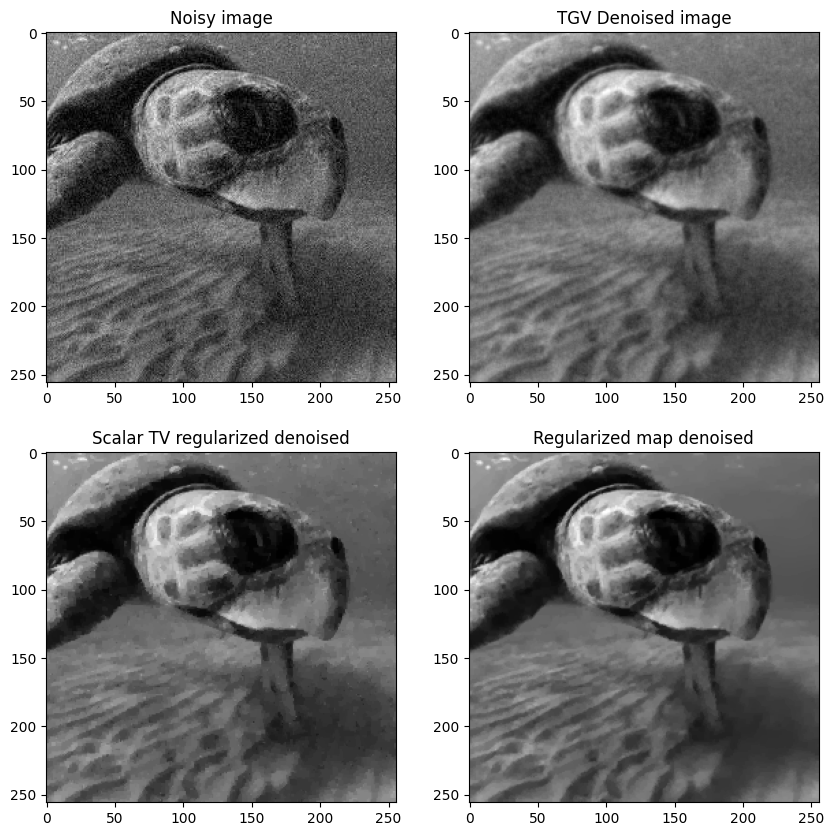

In [340]:
test_pdhg_tgv_numpy_on_image(file=example_file, alpha1=0.2, alpha0=2)

In [341]:
def get_pre_denoised(file):
    model = "06_24_19_56_05-50"
    extension = file.split(".")[-1]
    file = file.replace(f".{extension}", f"")
    pre_denoised_path = f"../../turtle_id/test/test_reg_map/{model}/test/{file}"
    reg_map_denoised = f"{pre_denoised_path}/denoised.png"
    scalar_reg_denoised = f"{pre_denoised_path}/scalar/best_PSNR.png"
    
    scalar_reg_denoised_img = Image.open(scalar_reg_denoised)
    plt.imshow(scalar_reg_denoised_img, cmap="gray")
    # scalar_reg_denoised_img.show()
    plt.title("Scalar regularized denoised")
    plt.close()
    
    reg_map_denoised_img = Image.open(reg_map_denoised)
    plt.imshow(reg_map_denoised_img, cmap="gray")
    # reg_map_denoised_img.show()
    plt.title("Regularized map denoised")
    plt.close()

In [342]:
get_pre_denoised(file=example_file)